# **Homework 2 (SLT 5B | CAMADO, M. | LACSON, A. | MANUEL, Y.)**

## 75% kNN Regressor (10 pts, due 10 February 2024, 10am)

Find a data set (not discussed here) that can achieve $R^2=$75% accuracy using k-NN (test set, use 20 trials at least). Perfect score (10/10) for >75% and -1 for every 1% decline in test accuracy, e.g., if your accuracy is 73.1%, you will get 8/10.

Every member of the SLT will get the same grade. Prepare for a 3-minute slide presentation of your use case for the recitation class.

**Submission Requirements**
1. *via ALICE* (due February 10, 10am)
  - Chosen Dataset
  - Python Notebook
  - Presentation Slides
2. in-class presentation (3 minutes)
  - during Session 11 (Saturday, February 10, 1:30pm-3pm)

In [2]:
pip install --upgrade joblib==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.10.1 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.
scikit-learn 1.2.2 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.


In [3]:
!pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import mglearn # library provided by amueller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's load our data and check its contents

Special thanks to Kaggle for sponsoring our data 🥳 <br>
Link to the data: https://www.kaggle.com/datasets/rinichristy/2022-fuel-consumption-ratings

In [6]:
data_dir = "/content/drive/MyDrive/MSDS Classes/ML1_P-MSDS2025/data/"
df_fuel = pd.read_csv(data_dir+'fuel_consumption.csv')
df_fuel.head()

,Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [7]:
df_fuel.shape

(946, 15)

In [8]:
df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model Year                         946 non-null    int64  
 1   Make                               946 non-null    object 
 2   Model                              946 non-null    object 
 3   Vehicle Class                      946 non-null    object 
 4   Engine Size(L)                     946 non-null    float64
 5   Cylinders                          946 non-null    int64  
 6   Transmission                       946 non-null    object 
 7   Fuel Type                          946 non-null    object 
 8   Fuel Consumption (City (L/100 km)  946 non-null    float64
 9   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 10  Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 11  Fuel Consumption(Comb (mpg))       946 non-null    int64  

Yay! We have no null values

### Let's enhance our dataset
We'll add the average curb weight per `Vehicle Class` since we will use this value to compute for power-to-weight ratio. Adding this ratio will enhance our dataset since this has a relationship with fuel consumption, which is the target of our regression model. It is known that the higher the power-to-weight ratio is, the lower the fuel consumption will be.<br><br>

Here are the references used to gather data on average curb weight by vehicle class:
- https://youramazingcar.com/average-weight-of-a-car/
- https://www.autolist.com/guides/average-weight-of-car

In [9]:
df_fuel['Vehicle Class'].value_counts()

SUV: Small                 197
SUV: Standard              141
Mid-size                   117
Pickup truck: Standard     113
Subcompact                  80
Compact                     69
Full-size                   64
Two-seater                  51
Minicompact                 48
Pickup truck: Small         20
Station wagon: Small        19
Special purpose vehicle     12
Station wagon: Mid-size      8
Minivan                      7
Name: Vehicle Class, dtype: int64

`Vehice Class` = `Special purpose vehicle` will be removed from the dataset since no proper average curb weight data can be found for this segment.

In [10]:
df_fuel.loc[df_fuel['Vehicle Class'] == 'Special purpose vehicle', ['Make', 'Model', 'Vehicle Class']].head()

,Make,Model,Vehicle Class
359,Ford,Transit Connect Van,Special purpose vehicle
360,Ford,Transit Connect Van FFV,Special purpose vehicle
361,Ford,Transit Connect Van FFV,Special purpose vehicle
362,Ford,Transit Connect Van,Special purpose vehicle
363,Ford,Transit Connect Wagon LWB,Special purpose vehicle


In [11]:
df_fuel.loc[df_fuel['Vehicle Class'] == 'Special purpose vehicle', ['Make', 'Model', 'Vehicle Class']].tail()

,Make,Model,Vehicle Class
366,Ford,Transit Connect Wagon LWB,Special purpose vehicle
691,Mercedes-Benz,Metris Cargo Van,Special purpose vehicle
692,Mercedes-Benz,Metris Cargo Van LWB,Special purpose vehicle
693,Mercedes-Benz,Metris Passenger Van,Special purpose vehicle
838,Ram,ProMaster City,Special purpose vehicle


In [12]:
df_fuel = df_fuel[df_fuel['Vehicle Class'] != 'Special purpose vehicle']

In [13]:
avg_weights = {'Two-seater': 730,
               'Compact': 1361,  # acura, volkswagen
               'Subcompact': 1136,  # mini cooper, audi sedan
               'Station wagon: Small': 998,
               'Station wagon: Mid-size': 1915,
               'SUV: Small': 1386,
               'SUV: Standard': 1996,
               'Mid-size': 1670,
               'Minicompact': 1630,  # porsche, subaru brz, aston martin
               'Full-size': 2165,
               'Pickup truck: Small': 1776,
               'Pickup truck: Standard': 2666,
               'Minivan': 2091}

In [14]:
for index, row in df_fuel.iterrows():
  for key, value in avg_weights.items():
    if row['Vehicle Class'] == key:
      df_fuel.loc[index, 'avg_curb_weight'] = value
      # df_fuel['avg_curb_weight'] = value

<ipython-input-14-6beb30adc464>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fuel.loc[index, 'avg_curb_weight'] = value


In [15]:
df_fuel.drop_duplicates(subset=['Vehicle Class', 'avg_curb_weight'])[['Vehicle Class', 'avg_curb_weight']]

,Vehicle Class,avg_curb_weight
0,Compact,1361.0
1,SUV: Small,1386.0
8,Mid-size,1670.0
14,Minicompact,1630.0
17,SUV: Standard,1996.0
18,Two-seater,730.0
19,Subcompact,1136.0
22,Station wagon: Small,998.0
28,Station wagon: Mid-size,1915.0
30,Full-size,2165.0


Above is the resulting snippet of the `df_fuel` where the `avg_curb_weight` data is added per `Vehicle Class`.<br><br>

Next, let's do our usual sanity check on our dataset for those anxious coders lol!

In [16]:
df_fuel.head()

,Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating,avg_curb_weight
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3,1361.0
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5,1386.0
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6,1386.0
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6,1386.0
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7,1361.0


In [17]:
df_fuel.shape

(934, 16)

In [18]:
df_fuel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 0 to 945
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model Year                         934 non-null    int64  
 1   Make                               934 non-null    object 
 2   Model                              934 non-null    object 
 3   Vehicle Class                      934 non-null    object 
 4   Engine Size(L)                     934 non-null    float64
 5   Cylinders                          934 non-null    int64  
 6   Transmission                       934 non-null    object 
 7   Fuel Type                          934 non-null    object 
 8   Fuel Consumption (City (L/100 km)  934 non-null    float64
 9   Fuel Consumption(Hwy (L/100 km))   934 non-null    float64
 10  Fuel Consumption(Comb (L/100 km))  934 non-null    float64
 11  Fuel Consumption(Comb (mpg))       934 non-null    int64  

Since our dataset contains categorical data, let's use `LabelEncoder()` from sklearn to assign numerical values to our categorical data. Let's also add "+1" to our encoded data to avoid 0 values. This will be useful later on in our modelling proper.

In [19]:
le = LabelEncoder()

make_label = le.fit_transform(df_fuel['Make'])
vehicle_class_label = le.fit_transform(df_fuel['Vehicle Class'])
transmission_label = le.fit_transform(df_fuel['Transmission'])
fuel_type_label = le.fit_transform(df_fuel['Fuel Type'])

df_fuel["make"] = make_label + 1
df_fuel["vehicle_class"] = vehicle_class_label + 1
df_fuel["transmission"] = transmission_label + 1
df_fuel["fuel_type"] = fuel_type_label + 1

In [20]:
df_fuel.head()

,Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating,avg_curb_weight,make,vehicle_class,transmission,fuel_type
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3,1361.0,1,1,8,4
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5,1386.0,1,8,9,4
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6,1386.0,1,8,9,4
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6,1386.0,1,8,9,4
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7,1361.0,1,1,9,4


In [21]:
fuel_type_check = df_fuel[["Fuel Type", "fuel_type"]].drop_duplicates().sort_values(by='fuel_type')
fuel_type_check.head()

,Fuel Type,fuel_type
160,D,1
198,E,2
19,X,3
0,Z,4


In [22]:
vehicle_class_check = df_fuel[["Vehicle Class", "vehicle_class"]].drop_duplicates().sort_values(by='vehicle_class')
vehicle_class_check.head()

,Vehicle Class,vehicle_class
0,Compact,1
30,Full-size,2
8,Mid-size,3
14,Minicompact,4
253,Minivan,5


The `df_fuel` snippet above shows how the original categorical data was assigned numerical values through `LabelEncoder()`.<br><br>

Next, let's look at our target. In the dataset, different fuel consumption data is available. We'll look at the basic statistics of each and generate histogram plots to have a better view of its distribution.

In [23]:
fuel_consumption_df = df_fuel.iloc[:, 8:13]
fuel_consumption_df.head()

,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km)
0,9.9,7.0,8.6,33,200
1,12.6,9.4,11.2,25,263
2,11.0,8.6,9.9,29,232
3,11.3,9.1,10.3,27,242
4,11.2,8.0,9.8,29,230


In [24]:
fuel_consumption_df.describe()

,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km)
count,934.000000,934.000000,934.000000,934.000000,934.000000
mean,12.515739,9.360921,11.096146,27.253747,259.450749
std,3.468690,2.295815,2.890418,7.724688,64.755052
min,4.000000,3.900000,4.000000,11.000000,94.000000
25%,10.200000,7.700000,9.100000,22.000000,213.000000
50%,12.200000,9.200000,10.800000,26.000000,258.000000
75%,14.700000,10.700000,12.900000,31.000000,301.750000
max,30.300000,20.900000,26.100000,71.000000,608.000000


Oh no! Seems like CO2 Emissions has a high standard deviation. We might want to scale this later on since we'll be using it for our model features.

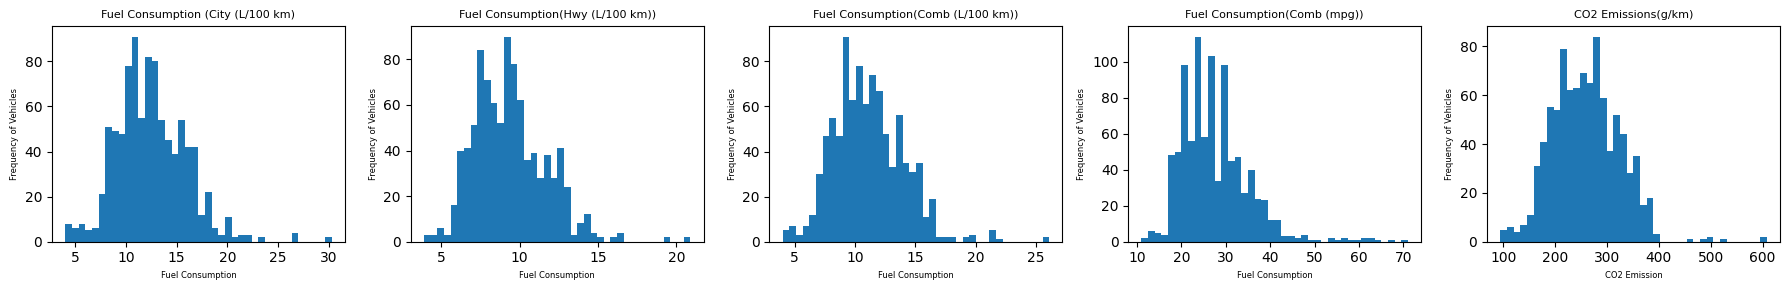

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
axes = axes.flatten()

for i, ax in zip(fuel_consumption_df.columns, axes):
  ax.hist(fuel_consumption_df[i], bins=40)
  if "CO2" in i:
    ax.set_xlabel('CO2 Emission', fontsize=6)
  else:
    ax.set_xlabel('Fuel Consumption', fontsize=6)
  ax.set_ylabel('Frequency of Vehicles', fontsize=6)
  ax.set_title(i, fontsize=8)

plt.tight_layout()
plt.show()

Looking at the histograms above,`Fuel Consumption(Comb (L/100km))` seems the most well-distributed across the variety of fuel consumption data that we have.According to Kaggle, where we got our dataset, this field considers 55% city and 45% highway fuel consumption. Best of both worlds! Let's use this as our target.<br><br>

Next, let's prepare our features for the model. We'll subset `df_fuel` to the columns that we only need and rename these said columns for uniformity (as an OC coder myself).

In [26]:
df_fuel = df_fuel[["make", "vehicle_class", "Engine Size(L)", "Cylinders", "transmission",
                   "fuel_type", "Fuel Consumption(Comb (L/100 km))", "CO2 Emissions(g/km)", "Smog Rating",
                   "avg_curb_weight"]]
colnames = {"Engine Size(L)":"engine_size", "Cylinders":"cylinders", "Fuel Consumption(Comb (L/100 km))":"fuel_consumption",
            "CO2 Emissions(g/km)":"co2_emission", "Smog Rating":"smog_rating"}
df_fuel = df_fuel.rename(columns=colnames)
df_fuel.head()

,make,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_consumption,co2_emission,smog_rating,avg_curb_weight
0,1,1,2.4,4,8,4,8.6,200,3,1361.0
1,1,8,3.5,6,9,4,11.2,263,5,1386.0
2,1,8,2.0,4,9,4,9.9,232,6,1386.0
3,1,8,2.0,4,9,4,10.3,242,6,1386.0
4,1,1,2.0,4,9,4,9.8,230,7,1361.0


Next, let's add the `power_to_weight ratio` column in `df_fuel`. This is computed by multiplying `engine_size` by 1000 to convert it to cc and then dividing this number by `avg_curb_weight` (in kg) to get the `power_to_weight_ratio`.

In [27]:
df_fuel['power_to_weight_ratio'] = (df_fuel['engine_size'] * 1000) / df_fuel['avg_curb_weight']
df_fuel.head()

,make,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_consumption,co2_emission,smog_rating,avg_curb_weight,power_to_weight_ratio
0,1,1,2.4,4,8,4,8.6,200,3,1361.0,1.763409
1,1,8,3.5,6,9,4,11.2,263,5,1386.0,2.525253
2,1,8,2.0,4,9,4,9.9,232,6,1386.0,1.443001
3,1,8,2.0,4,9,4,10.3,242,6,1386.0,1.443001
4,1,1,2.0,4,9,4,9.8,230,7,1361.0,1.469508


In [28]:
df_fuel.shape

(934, 11)

Then let's scale this variable since KNN regression is a distance-based algorithm and we want all our features to equally contribute to the distance calculations. Let's also include CO2 emissions in this scaling process since we found earlier that this has a high standard deviation.

In [29]:
ss = StandardScaler()
scaled_features = ss.fit_transform(df_fuel[['power_to_weight_ratio', 'co2_emission']])
df_fuel['pw_ratio_scaled'] = scaled_features[:, 0]
df_fuel['co2_emission_scaled'] = scaled_features[:, 1]

In [30]:
df_fuel = df_fuel.drop(columns=['power_to_weight_ratio', 'co2_emission'], axis=1)
df_fuel.head()

,make,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_consumption,smog_rating,avg_curb_weight,pw_ratio_scaled,co2_emission_scaled
0,1,1,2.4,4,8,4,8.6,3,1361.0,-0.235330,-0.918579
1,1,8,3.5,6,9,4,11.2,5,1386.0,0.385596,0.054840
2,1,8,2.0,4,9,4,9.9,6,1386.0,-0.496473,-0.424144
3,1,8,2.0,4,9,4,10.3,6,1386.0,-0.496473,-0.269633
4,1,1,2.0,4,9,4,9.8,7,1361.0,-0.474869,-0.455046


Let's put this clean and scaled `df_fuel` to a new DataFrame that we can play around with so it will be easier for us to create different model variations.

In [31]:
df_fuel_fnl = df_fuel

#### Let's run the model

Let's drop `fuel_consumption` since this is our target. Then, let's create `df_final_features` that will serve as our input to our model.

In [32]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features.head()

,make,vehicle_class,engine_size,cylinders,transmission,fuel_type,smog_rating,avg_curb_weight,pw_ratio_scaled,co2_emission_scaled
0,1,1,2.4,4,8,4,3,1361.0,-0.235330,-0.918579
1,1,8,3.5,6,9,4,5,1386.0,0.385596,0.054840
2,1,8,2.0,4,9,4,6,1386.0,-0.496473,-0.424144
3,1,8,2.0,4,9,4,6,1386.0,-0.496473,-0.269633
4,1,1,2.0,4,9,4,7,1361.0,-0.474869,-0.455046


Next, let's subset our DataFrame and only get the variables we intend to put in the model.

In [33]:
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'fuel_type', 'co2_emission_scaled']]
df_fuel_features.head()

,pw_ratio_scaled,fuel_type,co2_emission_scaled
0,-0.235330,4,-0.918579
1,0.385596,4,0.054840
2,-0.496473,4,-0.424144
3,-0.496473,4,-0.269633
4,-0.474869,4,-0.455046


Finally, let's run our model! We'll simulate our model across different neighbor settings and seed values to help us with hyperparameter tuning. A test size of 25% is used.

In [34]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

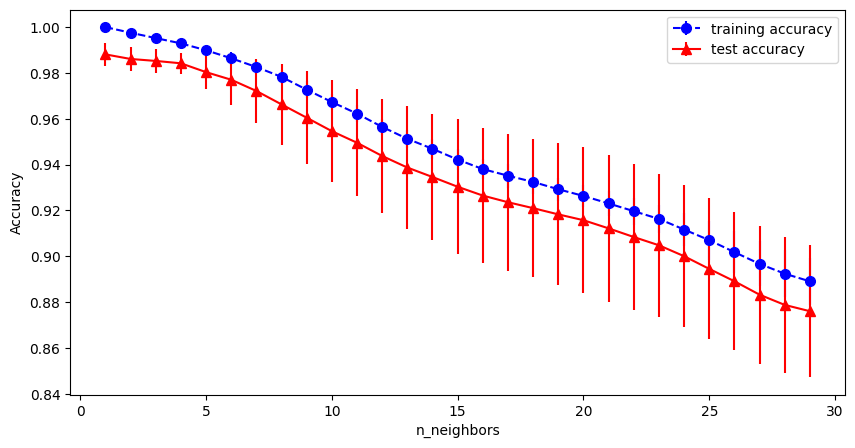

In [35]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

In the plot above, it can be seen that the test set accuracy peaked at 4 neighbors. Let's use this neighbor setting for our final model. It can also be observed that the standard deviation for the test accuracy increases as the number of neighbors increase. This demonstrates the "smoothing effect" where the model becomes less sensitive to individual data points as the number of neighbors increase. This effect may lead to a decrease in the consistency of the model's accuracy; thus, giving high accuracy standard deviations.

0.9846795398873648


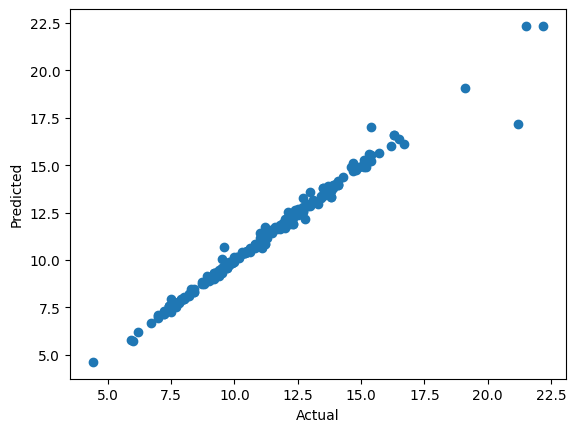

In [36]:
reg = KNeighborsRegressor(n_neighbors=4)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

print(r2_score(y_test, reg.predict(X_test)))

Our model yielded a R-squared value of 98.47%. Great!<br><br>

Next, let's look at other performance metrics since we want to have a more comprehensive understanding of our model's performance.

In [37]:
r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
adj_r

0.9846301190482918

We got an adjusted R-squared of 98.46% yay!. This just means that all the variables we chose for our model gives meaningful information to the model since adjusted r-squared penalizes the inclusion of irrelevant predictors.

In [38]:
mean_absolute_error(y_test, reg.predict(X_test))

0.1482905982905984

We also calculated for the mean absolute error. On average, the model's predictions are off by 0.15 liters. This means that, considering all predictions, the model tends to be approximately 0.15 liters away from the true fuel consumption.

#### adding relationships between 2 variables

In [39]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'transmission', 'fuel_type', 'engine_size', 'cylinders']]
df_fuel_features.head()

,pw_ratio_scaled,transmission,fuel_type,engine_size,cylinders
0,-0.235330,8,4,2.4,4
1,0.385596,9,4,3.5,6
2,-0.496473,9,4,2.0,4
3,-0.496473,9,4,2.0,4
4,-0.474869,9,4,2.0,4


Let's get the relationship between `engine_size` and `cylinders` by multiplying the two variables.

In [40]:
df_fuel_features["engine_size_x_cylinders"] = df_fuel_features["engine_size"] * df_fuel_features["cylinders"]
df_fuel_features.head()

,pw_ratio_scaled,transmission,fuel_type,engine_size,cylinders,engine_size_x_cylinders
0,-0.235330,8,4,2.4,4,9.6
1,0.385596,9,4,3.5,6,21.0
2,-0.496473,9,4,2.0,4,8.0
3,-0.496473,9,4,2.0,4,8.0
4,-0.474869,9,4,2.0,4,8.0


In [41]:
df_fuel_features = df_fuel_features.drop(columns=["engine_size", "cylinders"])
df_fuel_features.head()

,pw_ratio_scaled,transmission,fuel_type,engine_size_x_cylinders
0,-0.235330,8,4,9.6
1,0.385596,9,4,21.0
2,-0.496473,9,4,8.0
3,-0.496473,9,4,8.0
4,-0.474869,9,4,8.0


Let's scale the new variable we made since it is a continuous variable (float).

In [42]:
ss = StandardScaler()
engine_x_cylinder_scaled = ss.fit_transform(df_fuel_features['engine_size_x_cylinders'].to_numpy().reshape(-1, 1))
df_fuel_features['engine_x_cylinder_scaled'] = engine_x_cylinder_scaled

In [43]:
df_fuel_features = df_fuel_features.drop(columns=['engine_size_x_cylinders'], axis=1)
df_fuel_features.head()

,pw_ratio_scaled,transmission,fuel_type,engine_x_cylinder_scaled
0,-0.235330,8,4,-0.675707
1,0.385596,9,4,0.016393
2,-0.496473,9,4,-0.772843
3,-0.496473,9,4,-0.772843
4,-0.474869,9,4,-0.772843


Above is the final features we will be using for the model. Let's input this in our regression model using the same approach we did earlier.

In [44]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

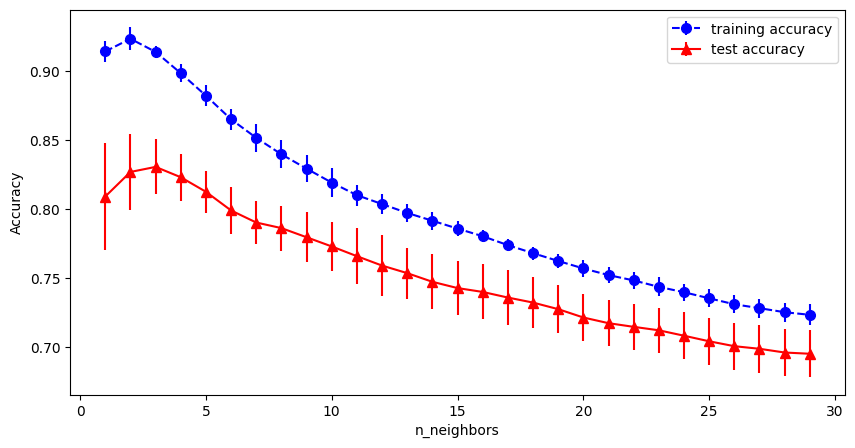

In [45]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

Sadly, this set of variables yielded a lower model accuracy, but this is still acceptable nonetheless. The variability in the test accuracy as number of neighbors increase is lesser using these variables. Not bad!<br><br>

Let's use 3 as the value for our $k$ since this is where the test accuracy peaked.

R-squared: 80.62%
Adj R-squared: 80.53%
Mean Absolute Error: 0.91 L/100km


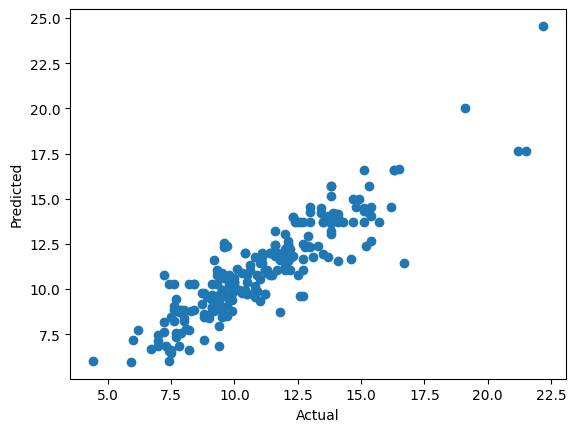

In [46]:
reg = KNeighborsRegressor(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")

The model adding the relationship of `engine_size` and `cylinders` yielded an R-squared of 80.6%. The plot above showing actual vs. predicted values shows a trend; however, it seems more scattered than the first model we made. At least we explored other options :)

After playing around with the different variables available. We found out that `co2_emission_scaled` makes the model performance statistics shoot up! This is probably because of the inherent linear relationship between co2 emission and fuel consumption. Below are the model iterations done to prove this.

#### without co2 emission

In [63]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'fuel_type', 'transmission']]
df_fuel_features.head()

,pw_ratio_scaled,fuel_type,transmission
0,-0.235330,4,8
1,0.385596,4,9
2,-0.496473,4,9
3,-0.496473,4,9
4,-0.474869,4,9


In [64]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

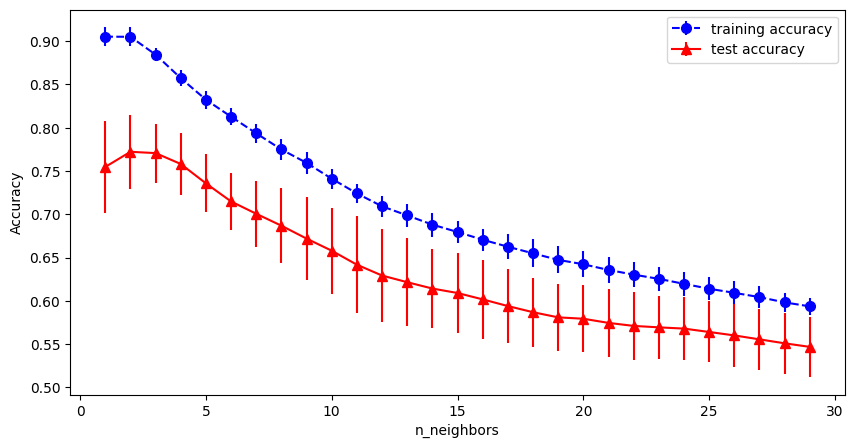

In [65]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

R-squared: 74.63%
Adj R-squared: 74.55%
Mean Absolute Error: 1.04 L/100km


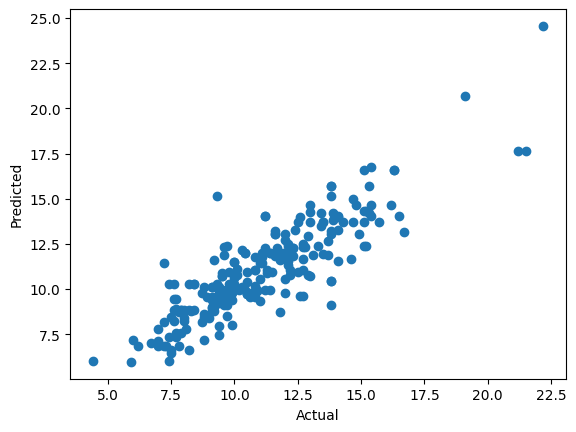

In [66]:
reg = KNeighborsRegressor(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")

#### with co2 emission

In [68]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'fuel_type', 'transmission', 'co2_emission_scaled']]
df_fuel_features.head()

,pw_ratio_scaled,fuel_type,transmission,co2_emission_scaled
0,-0.235330,4,8,-0.918579
1,0.385596,4,9,0.054840
2,-0.496473,4,9,-0.424144
3,-0.496473,4,9,-0.269633
4,-0.474869,4,9,-0.455046


In [69]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

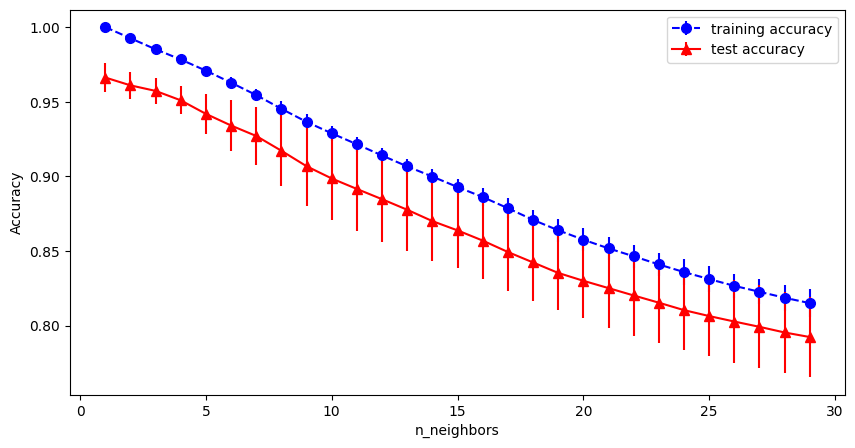

In [70]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

R-squared: 95.37%
Adj R-squared: 95.35%
Mean Absolute Error: 0.36 L/100km


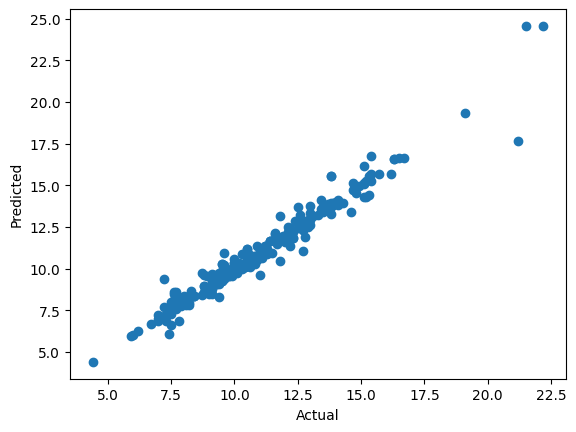

In [71]:
reg = KNeighborsRegressor(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")

#### without pw ratio

In [51]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['engine_size', 'fuel_type', 'transmission', 'cylinders']]
df_fuel_features.head()

,engine_size,fuel_type,transmission,cylinders
0,2.4,4,8,4
1,3.5,4,9,6
2,2.0,4,9,4
3,2.0,4,9,4
4,2.0,4,9,4


In [52]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

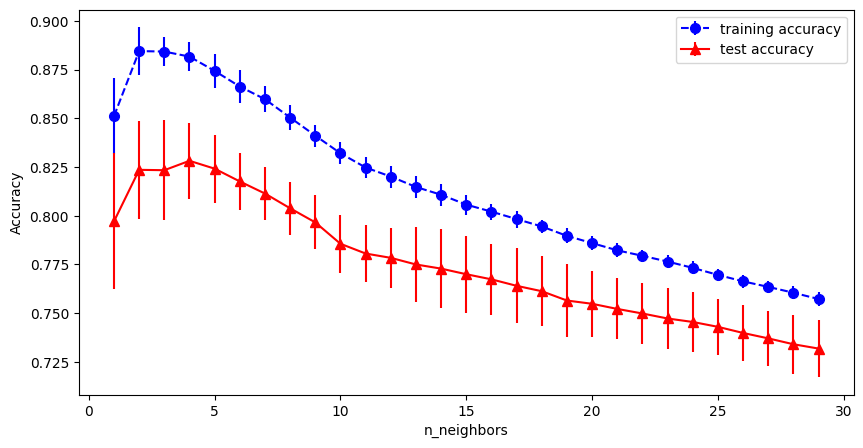

In [53]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

R-squared: 82.58%
Adj R-squared: 82.50%
Mean Absolute Error: 0.85 L/100km


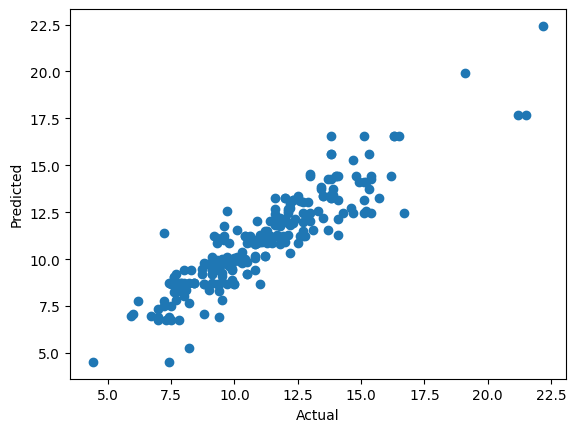

In [54]:
reg = KNeighborsRegressor(n_neighbors=4)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")

#### with pw ratio

In [55]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'co2_emission_scaled', 'cylinders', 'fuel_type']]
df_fuel_features.head()

,pw_ratio_scaled,co2_emission_scaled,cylinders,fuel_type
0,-0.235330,-0.918579,4,4
1,0.385596,0.054840,6,4
2,-0.496473,-0.424144,4,4
3,-0.496473,-0.269633,4,4
4,-0.474869,-0.455046,4,4


In [56]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

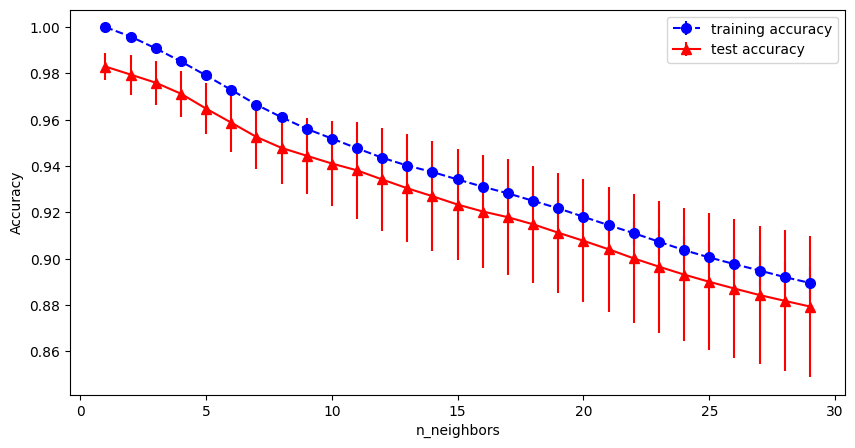

In [57]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

R-squared: 95.35%
Adj R-squared: 95.33%
Mean Absolute Error: 0.24 L/100km


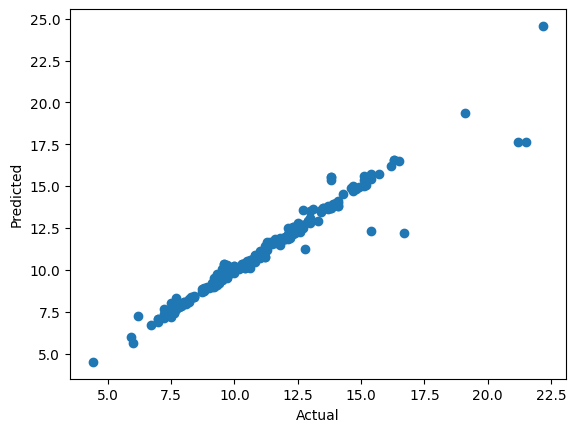

In [58]:
reg = KNeighborsRegressor(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")

#### with pw ratio but lesser number of variables

In [59]:
df_fuel_features = df_fuel_fnl.drop(columns=['fuel_consumption'], axis=1)
df_fuel_features = df_fuel_features[['pw_ratio_scaled', 'cylinders', 'fuel_type']]
df_fuel_features.head()

,pw_ratio_scaled,cylinders,fuel_type
0,-0.235330,4,4
1,0.385596,6,4
2,-0.496473,4,4
3,-0.496473,4,4
4,-0.474869,4,4


In [60]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,10,1):
    X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel_fnl['fuel_consumption'], test_size=0.25, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 30) # try n_neighbors from 1 to 10

    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train)
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN] = training_accuracy
    all_test[seedN] = test_accuracy

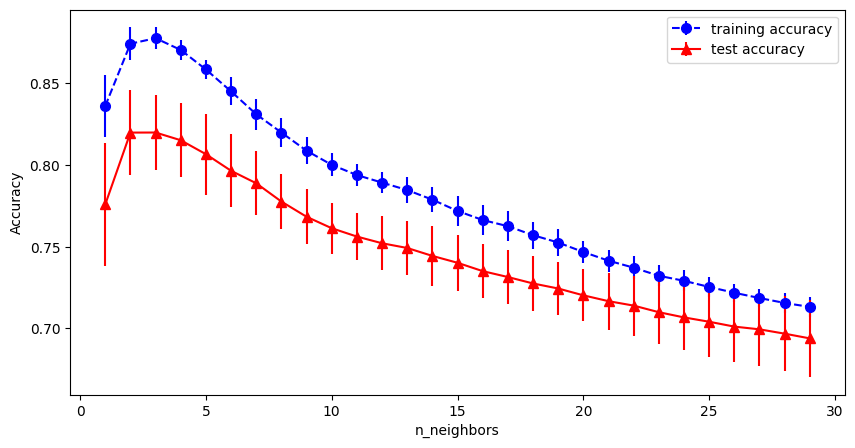

In [61]:
fig = plt.figure(figsize=(10, 5))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=7)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=7)
plt.ylabel("Accuracy", fontsize=10)
plt.xlabel("n_neighbors",fontsize=10)
plt.legend(fontsize=10)

R-squared: 80.05%
Adj R-squared: 79.99%
Mean Absolute Error: 0.91 L/100km


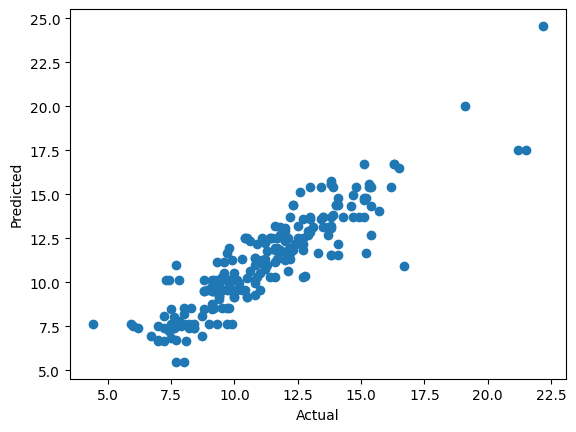

In [62]:
reg = KNeighborsRegressor(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(df_fuel_features, df_fuel['fuel_consumption'], test_size=0.25, random_state=seedN)
reg.fit(X_train, y_train)

plt.plot( y_test, reg.predict(X_test), 'o')

plt.xlabel("Actual")
plt.ylabel("Predicted")

r2 = r2_score(y_test, reg.predict(X_test))
adj_r = 1 - ((1-r2)*((df_fuel_features.shape[0] - 1) / (df_fuel_features.shape[0] - df_fuel_features.shape[1] - 1)))
mae = mean_absolute_error(y_test, reg.predict(X_test))

print(f"R-squared: {r2*100:.2f}%")
print(f"Adj R-squared: {adj_r*100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f} L/100km")